In [2]:
import pandas as pd
import json

In [3]:
# Load JSON file
with open('chat_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

flattened_data = []

# Iterate through each room
for room_id, room_data in data.items():
    last_message_time = room_data.get('last_message_time', '')
    messages = room_data.get('messages', [])

    for message in messages:
        # Check if content is image url
        if isinstance(message.get('content'), list):
            image_url = message.get('content')[0].get('image_url', {}).get('url')
            text = ""
        else:
            image_url = ""
            text = message.get('content', '')

        flattened_data.append({
            'room_id': room_id,
            'last_message_time': last_message_time,
            'role': message['role'],
            'text': text,
            'image_url': image_url,
            'timestamp': message.get('timestamp', '')
        })
            


df = pd.DataFrame(flattened_data)

In [4]:
# Remove the sample room

df = df[df['room_id'] != "000000000"]

In [5]:
df

,room_id,last_message_time,role,text,image_url,timestamp
1,276140794,2024-11-29T04:04:58.190102,user,hi,,2024-11-29T04:04:58.190102
2,276140794,2024-11-29T04:04:58.190102,assistant,"Hi there! I'm Jib AI, your friendly health ass...",,
3,276178456,2024-12-11T03:29:43.308172,user,hello,,2024-11-22T03:52:02.520194
4,276178456,2024-12-11T03:29:43.308172,assistant,"Hi there! I'm Jib AI, your friendly health ass...",,
5,276178456,2024-12-11T03:29:43.308172,user,what are causes of gerd?,,2024-11-22T04:01:45.683628
...,...,...,...,...,...,...
11513,285248154,2024-12-20T08:10:54.265995,assistant,สวัสดีค่ะ อาการปวดแขนอาจเกิดจากหลายสาเหตุ เช่น...,,
11514,285248751,2024-12-20T08:19:12.817386,user,อยากจะรู้รางจืดกินอย่างไร กินตอนไหนบ้าง,,2024-12-20T08:14:22.395719
11515,285248751,2024-12-20T08:19:12.817386,assistant,รางจืดเป็นสมุนไพรที่มีสรรพคุณช่วยล้างพิษในร่าง...,,
11516,285248751,2024-12-20T08:19:12.817386,user,ขนาดรับประทานแต่และครั้งเท่าไหร,,2024-12-20T08:19:12.817386


In [6]:
df.isnull().sum()

room_id              0
last_message_time    0
role                 0
text                 0
image_url            0
timestamp            0
dtype: int64

In [7]:
# Convert timestamp strings to timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['last_message_time'] = pd.to_datetime(df['last_message_time'])

In [8]:
from pythainlp import word_tokenize
from pythainlp.corpus.common import thai_stopwords

thai_stopwords = list(thai_stopwords())

def text_process(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":", "!", '"', "ๆ", "ฯ"))
    final = word_tokenize(final)
    final = " ".join(word for word in final)
    final = " ".join(word for word in final.split() if word.lower not in thai_stopwords)
    return final

# Apply the function to the 'text' column and create the 'text_tokens' column
df['text_tokens'] = df['text'].apply(text_process)

### BASIC STATISTICS (EDA)

In [9]:
# Number of messages by room_id
message_count_by_room = df['room_id'].value_counts()
message_count_by_room

room_id
283740504    479
283175257    188
276178456    123
281568379    116
282250770    115
            ... 
282778054      2
282776366      2
282774302      2
282773291      2
283103426      2
Name: count, Length: 2110, dtype: int64

In [10]:
# Number of messages by role (user vs assistant)
message_count_by_role = df['role'].value_counts()
message_count_by_role

role
user         6439
assistant    5078
Name: count, dtype: int64

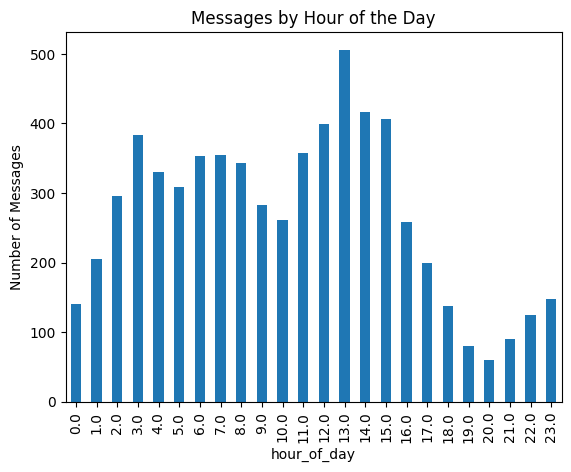

In [11]:
# Most Active Times

# Extract hour of the day from the timestamp
df['hour_of_day'] = df['timestamp'].dt.hour

# Plot the number of messages by hour of the day
import matplotlib.pyplot as plt

df.groupby('hour_of_day').size().plot(kind='bar', title="Messages by Hour of the Day")
plt.ylabel('Number of Messages')
plt.show()

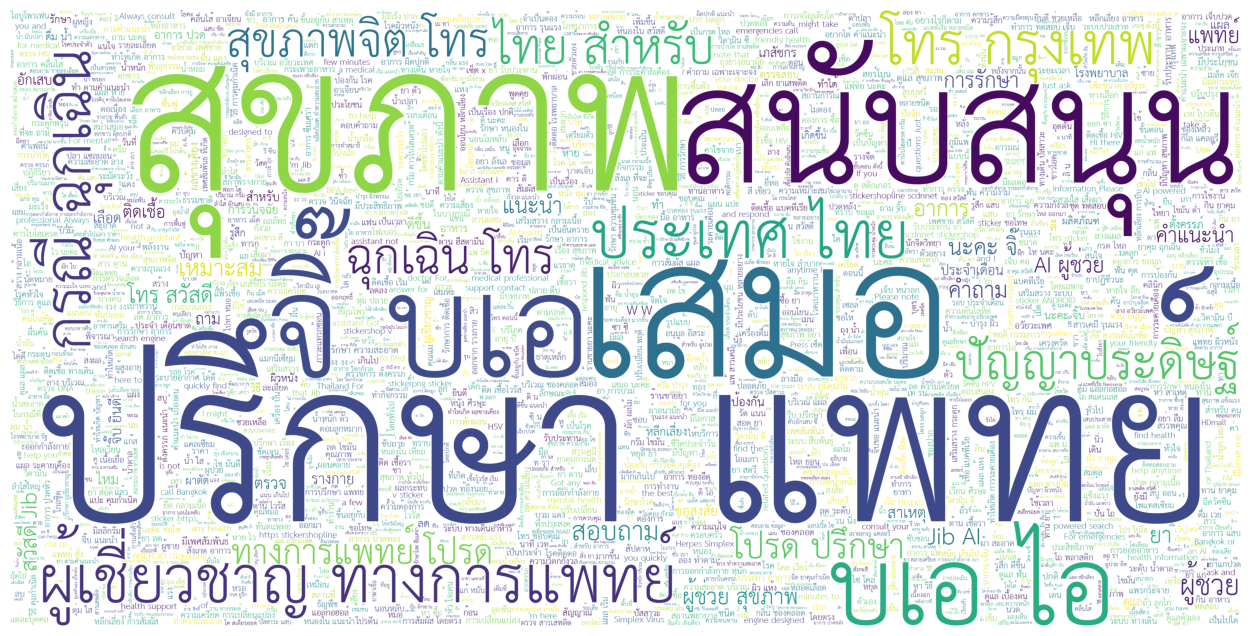

In [12]:
from wordcloud import WordCloud, STOPWORDS

# Combine all texts into one string
text_combined = ' '.join(text for text in df['text_tokens'])
reg = r"[ก-๙a-zA-Z']+"
fp = "THSarabunNew.ttf"

# Generate word cloud
wc = WordCloud(stopwords=thai_stopwords, background_color='white', max_words=2000, height=2000, width=4000, font_path=fp, regexp=reg).generate(text_combined)

# Plot the word cloud
plt.figure(figsize=(16, 8))
plt.imshow(wc)
plt.axis('off')
plt.show()

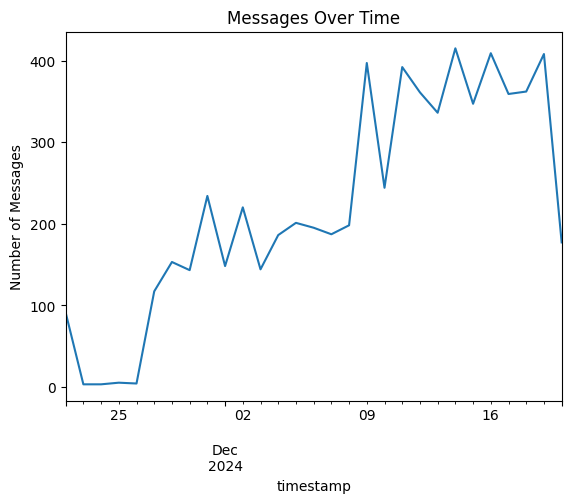

In [13]:
df.set_index('timestamp', inplace=True)
messages_per_day = df.resample('D').size()

# Plot messages over time
messages_per_day.plot(kind='line', title="Messages Over Time")
plt.ylabel('Number of Messages')
plt.show()

### ANALYSIS